# Wrangle and Analyze Data

## Introduction
The purpose of this project is to wrangle and analyze data from WeRateDogs, a humorous Twitter account that rates dog photos. I will gather data from various sources, in several formats, assess the quality of the data, clean it, and then provide analysis. 

From the course **Project Details**, the tasks to accomplish are:
- Data wrangling, which consists of:
 - Gathering data
 - Assessing data
 - Cleaning data
- Storing, analyzing, and visualizing your wrangled data
- Reporting on 1) your data wrangling efforts and 2) your data analyses and visualizations

#### Imports
Import libraries as dictacted by project description.

In [194]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import tweepy
import requests as rq
import time
import json

pd.set_option('display.max_colwidth', 30)

## Gathering Data
#### Open DogRates Twitter Archive with *Pandas*
This file was provided as-is. Open *twitter-archive-enhanced.csv* with Pandas.

In [195]:
# Specific Dtypes for columns and date columns to parse
archive_dtypes = {'tweet_id':str, 'in_reply_to_status_id': str, 'in_reply_to_user_id': str,
                  'retweeted_status_id': str, 'retweeted_status_user_id': str, 'rating_numerator': int,
                  'rating_denomenator': int}
archive_parse_dates = ['timestamp', 'retweeted_status_timestamp']

archive_df = pd.read_csv('twitter-archive-enhanced.csv', dtype=archive_dtypes, parse_dates=archive_parse_dates)
archive_df.set_index('tweet_id', inplace=True)

#### Get Tweets with *Tweepy*
Download the detailed tweet data from Twitter using Tweepy. Save the data to *tweet_json.txt* once downloaded.

If the file exists, open it locally to avoid redownloading. (The download takes approximately 30 minutes to complete due to API rate-limiting because extended tweets are not supported by the Tweepy bulk-download function.)

In [196]:
retry_count = 0

while True:
    try:
        # open tweet detailed tweet archive file saved locally
        with open('tweet_json.txt', 'r') as fr:
            tweets_df = pd.io.json.json_normalize(
                        json.load(fr)
                     )
        break
    
    except FileNotFoundError as e:
        # list of tweets to download from the archive file
        tweet_ids = archive_df.tweet_id.unique().tolist()
        tweets = []

        for t in tweet_ids:
            try:
                # Parsing Tweepy objects: https://stackoverflow.com/questions/27900451
                
                twitter_keys = {"ConsumerAPIKey":None,
                                "ConsumerSecret":None,
                                "AccessToken":None,
                                "AccessTokenSecret":None}
                # comment this out and insert values to twitter_keys above if using other Twitter API keys
                twitter_keys = pd.read_json('twitterkeys.json', typ='series')
                
                twitter_auth = tweepy.OAuthHandler(twitter_keys['ConsumerAPIKey'], twitter_keys['ConsumerSecret'])
                twitter_auth.set_access_token(twitter_keys['AccessToken'], twitter_keys['AccessTokenSecret'])
                twitter = tweepy.API(twitter_auth, parser=tweepy.parsers.JSONParser(),
                                     wait_on_rate_limit=True,
                                     wait_on_rate_limit_notify=True)

                # get tweets one-by-one because tweepy.statuses_lookup doesn't support tweet_mode=extended
                tweets.append(
                    twitter.get_status(t, tweet_mode='extended', include_entities=True, trim_user=True)
                )

            except tweepy.TweepError as te:
                #swallow 'status not found' errors, raise all others
                if(te.api_code != 144):
                    raise

            #delay to reduce request rate; 15m limiting causes proxy timeout on intranet    
            time.sleep(.2)

        # write file to disk to avoid re-downloading
        with open('tweet_json.txt', 'w') as fw:
            json.dump(tweets, fw)
        
        # if met maximum retries, raise an error
        retry_count = retry_count + 1
        if retry_count == 4:
            raise

#### Download Image Predictions with *Requests*

Download the image predictions file using the Requests library. Save the file locally as *image-predictions.tsv*. If the file was already downloaded, open it locally to avoid hitting the server for the same file many times.

In [197]:
retry_count = 0

while True:
    try: 
        # Open image prediction file saved locally
        images_df = pd.read_csv('image-predictions.tsv', sep='\t', dtype={'tweet_id':str}).set_index('tweet_id')
        break
    
    except FileNotFoundError as e:
        # Use Requests library to download
        image_predictions_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

        # Save the file
        with open('image-predictions.tsv', 'w') as fr:
            r = rq.get(image_predictions_url).text
            fr.write(r)
        
        # if met maximum retries, raise an error
        retry_count = retry_count + 1
        if retry_count == 4:
            raise

## Assessing Data

#### Columns of Archive data

In [198]:
archive_df.head()

in_reply_to_status_id in_reply_to_user_id  \
tweet_id                                                       
892420643555336193                   NaN                 NaN   
892177421306343426                   NaN                 NaN   
891815181378084864                   NaN                 NaN   
891689557279858688                   NaN                 NaN   
891327558926688256                   NaN                 NaN   

                             timestamp                         source  \
tweet_id                                                                
892420643555336193 2017-08-01 16:23:56  <a href="http://twitter.co...   
892177421306343426 2017-08-01 00:17:27  <a href="http://twitter.co...   
891815181378084864 2017-07-31 00:18:03  <a href="http://twitter.co...   
891689557279858688 2017-07-30 15:58:51  <a href="http://twitter.co...   
891327558926688256 2017-07-29 16:00:24  <a href="http://twitter.co...   

                                             text retweeted_status_id  \
tweet_id                                                                
892420643555336193  This is Phineas. He's a my...                 NaN   
892177421306343426  This is Tilly. She's just ...                 NaN   
891815181378084864  This is Archie. He is a ra...                 NaN   
891689557279858688  This is Darla. She commenc...                 NaN   
891327558926688256  This is Franklin. He would...                 NaN   

                   retweeted_status_user_id retweeted_status_timestamp  \
tweet_id                                                                 
892420643555336193                      NaN                        NaT   
892177421306343426                      NaN                        NaT   
891815181378084864                      NaN                        NaT   
891689557279858688                      NaN                        NaT   
891327558926688256                      NaN                        NaT   

                                    expanded_urls  rating_numerator  \
tweet_id                                                              
892420643555336193  https://twitter.com/dog_ra...                13   
892177421306343426  https://twitter.com/dog_ra...                13   
891815181378084864  https://twitter.com/dog_ra...                12   
891689557279858688  https://twitter.com/dog_ra...                13   
891327558926688256  https://twitter.com/dog_ra...                12   

                    rating_denominator      name doggo floofer pupper puppo  
tweet_id                                                                     
892420643555336193                  10   Phineas  None    None   None  None  
892177421306343426                  10     Tilly  None    None   None  None  
891815181378084864                  10    Archie  None    None   None  None  
891689557279858688                  10     Darla  None    None   None  None  
891327558926688256                  10  Franklin  None    None   None  None

In [199]:
list(archive_df)

['in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

Several columns contain data not necessary for this analysis. I intend to remove them for clarity below. Slated for removal:
- in_reply_to_status_id
- in_reply_to_user_id
- source
- retweeted_status_user_id
- retweeted_status_timestamp

#### Rating Denominators

In [200]:
archive_df.rating_denominator.value_counts(sort=False)

0         1
2         1
10     2333
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
7         1
11        3
15        1
Name: rating_denominator, dtype: int64

Rating are almost exclusively out of 10. Ratings out of a multiple of 10 tend to contain multiple dogs. Let's look in to the outlier rating denominators.

In [201]:
c_denom = [0, 2, 7, 11, 15, 16]
archive_df[archive_df.rating_numerator.isin(c_denom)][['text', 'rating_numerator', 'rating_denominator']]

text  rating_numerator  \
tweet_id                                                              
880095782870896641  Please don't send in photo...                11   
879050749262655488  This is Steven. He has tro...                11   
878316110768087041  RT @dog_rates: Meet Terran...                11   
870804317367881728  Real funny guys. Sending i...                11   
862722525377298433  This is Dave. He passed th...                11   
854010172552949760  At first I thought this wa...                11   
851591660324737024  Oh jeez u did me quite the...                11   
850753642995093505  This is Kyle. He made a jo...                11   
850145622816686080  This is Riley. He's making...                11   
849336543269576704  At first I thought this wa...                11   
848213670039564288  Jerry just apuppologized t...                11   
847978865427394560  RT @dog_rates: This is Cha...                11   
847157206088847362  Meet Daisy. She's been pup...                11   
847116187444137987  Unbelievable... We. Only. ...                11   
846505985330044928  THIS WAS NOT HIS FAULT HE ...                11   
844580511645339650  This is Charlie. He wants ...                11   
843604394117681152  This is Hank. He's been ou...                11   
838916489579200512  RT @KibaDva: I collected a...                15   
838085839343206401  @bragg6of8 @Andy_Pace_ we ...                15   
836677758902222849  Say hello to Oliver. He's ...                11   
836648853927522308  RT @SchafeBacon2016: @dog_...                11   
835574547218894849  This is Eli. He works back...                11   
835152434251116546  When you're so blinded by ...                 0   
834167344700198914  This is Sunshine. She does...                11   
832369877331693569  This is Charlie. He fell a...                11   
832088576586297345  @docmisterio account start...                11   
829449946868879360  Here's a stressed doggo. H...                11   
828011680017821696  Say hello to Brutus and Je...                11   
826598799820865537  I was going to do 007/10, ...                 7   
826240494070030336  We only rate dogs. Please ...                11   
...                                           ...               ...   
668614819948453888  Here is a horned dog. Much...                 7   
668567822092664832  This is Marvin. He can tie...                11   
668480044826800133  Say hello to DayZ. She is ...                11   
668286279830867968  Meet Rusty. Rusty's dreami...                11   
668171859951755264  This is a Trans Siberian K...                 7   
668142349051129856  This lil pup is Oliver. Ho...                 2   
667886921285246976  This is Erik. He's fucken ...                11   
667878741721415682  This is Tedrick. He lives ...                 2   
667728196545200128  Meet Olive. He comes to sp...                11   
667724302356258817  What a dog to start the da...                 7   
667502640335572993  Say hello to Hall and Oate...                11   
667491009379606528  Two dogs in this one. Both...                 7   
667470559035432960  This is a northern Wahoo n...                11   
667455448082227200  This is Reese and Twips. R...                 7   
667453023279554560  Meet Cupcake. I would do u...                11   
667405339315146752  This is Biden. Biden just ...                 7   
667200525029539841  This is Joshwa. He is a fu...                11   
667160273090932737  This is Bradlay. He is a R...                11   
667090893657276420  This is Clybe. He is an An...                 7   
666983947667116034  This is a curly Ticonderog...                11   
666786068205871104  Unfamiliar with this breed...                 2   
666437273139982337  Here we see a lone northea...                 7   
666428276349472768  Here we have an Austrian P...                 7   
666411507551481857  This is quite the dog. Get...                 2  

All of the above ratings appear to be incorrect and will be corrected in the cleaning section below.

#### Rating Numerators

In [202]:
archive_df.rating_numerator.value_counts(sort=False)

0         2
2         9
4        17
6        32
8       102
10      461
12      558
14       54
20        1
24        1
26        1
44        1
50        1
60        1
80        1
84        1
88        1
144       1
182       1
204       1
420       2
666       1
960       1
1776      1
1         9
3        19
5        37
7        55
9       158
11      464
13      351
15        2
17        1
27        1
45        1
75        2
99        1
121       1
143       1
165       1
Name: rating_numerator, dtype: int64

There are many more possible numerators, but a few stand out as outliers or non-conforming.

In [203]:
c_numer = [0, 420, 666, 1776]
archive_df[archive_df.rating_numerator.isin(c_numer)][['text', 'rating_numerator', 'rating_denominator']]

text  rating_numerator  \
tweet_id                                                              
855862651834028034  @dhmontgomery We also gave...               420   
855860136149123072  @s8n You tried very hard t...               666   
835152434251116546  When you're so blinded by ...                 0   
749981277374128128  This is Atticus. He's quit...              1776   
746906459439529985  PUPDATE: can't see any. Ev...                 0   
670842764863651840  After so many requests... ...               420   

                    rating_denominator  
tweet_id                                
855862651834028034                  10  
855860136149123072                  10  
835152434251116546                  10  
749981277374128128                  10  
746906459439529985                  10  
670842764863651840                  10

Since joke ratings seem valid for a humor account, the tweets that feature dogs will be kept for now. The Snoop Dogg tweet and tweets without dogs will be deleted.

#### Names

In [204]:
archive_df.name.value_counts()

None           745
a               55
Charlie         12
Lucy            11
Cooper          11
Oliver          11
Penny           10
Lola            10
Tucker          10
Winston          9
Bo               9
the              8
Sadie            8
Toby             7
Bailey           7
an               7
Daisy            7
Buddy            7
Jack             6
Milo             6
Dave             6
Bella            6
Koda             6
Leo              6
Oscar            6
Scout            6
Jax              6
Rusty            6
Stanley          6
Sunny            5
              ... 
Finnegus         1
Margo            1
Jomathan         1
Suki             1
Zuzu             1
Reptar           1
Cuddles          1
Maya             1
Cermet           1
Tom              1
Mitch            1
Tino             1
Millie           1
Gin              1
Diogi            1
Jazzy            1
Shakespeare      1
Pluto            1
Kane             1
Jordy            1
Obie             1
Angel       

A large set of tweets have dogs named 'None'. Let's see if that's correct.

In [205]:
archive_df[archive_df.name == 'None'].sample(20, random_state=1210)

in_reply_to_status_id in_reply_to_user_id  \
tweet_id                                                        
867900495410671616                    NaN                 NaN   
681340665377193984  6.813394486558024e+17        4196983835.0   
686034024800862208                    NaN                 NaN   
714214115368108032                    NaN                 NaN   
800855607700029440                    NaN                 NaN   
677334615166730240                    NaN                 NaN   
684122891630342144                    NaN                 NaN   
692142790915014657  6.920419346894029e+17        4196983835.0   
776218204058357768                    NaN                 NaN   
829449946868879360                    NaN                 NaN   
691096613310316544                    NaN                 NaN   
674606911342424069  6.744688808997888e+17        4196983835.0   
670826280409919488                    NaN                 NaN   
666649482315059201                    NaN                 NaN   
756275833623502848                    NaN                 NaN   
678023323247357953  6.780211157180293e+17        4196983835.0   
798694562394996736                    NaN                 NaN   
759566828574212096                    NaN                 NaN   
692752401762250755                    NaN                 NaN   
675432746517426176                    NaN                 NaN   

                             timestamp                         source  \
tweet_id                                                                
867900495410671616 2017-05-26 00:29:37  <a href="http://twitter.co...   
681340665377193984 2015-12-28 05:07:27  <a href="http://twitter.co...   
686034024800862208 2016-01-10 03:57:12  <a href="http://twitter.co...   
714214115368108032 2016-03-27 22:14:49  <a href="http://twitter.co...   
800855607700029440 2016-11-22 00:17:10  <a href="http://twitter.co...   
677334615166730240 2015-12-17 03:48:51  <a href="http://twitter.co...   
684122891630342144 2016-01-04 21:23:02  <a href="http://twitter.co...   
692142790915014657 2016-01-27 00:31:15  <a href="http://twitter.co...   
776218204058357768 2016-09-15 00:36:55  <a href="http://twitter.co...   
829449946868879360 2017-02-08 22:00:52  <a href="http://twitter.co...   
691096613310316544 2016-01-24 03:14:07  <a href="http://twitter.co...   
674606911342424069 2015-12-09 15:09:55  <a href="http://twitter.co...   
670826280409919488 2015-11-29 04:47:03  <a href="http://twitter.co...   
666649482315059201 2015-11-17 16:09:56  <a href="http://twitter.co...   
756275833623502848 2016-07-21 23:53:04  <a href="http://twitter.co...   
678023323247357953 2015-12-19 01:25:31  <a href="http://twitter.co...   
798694562394996736 2016-11-16 01:09:57  <a href="http://twitter.co...   
759566828574212096 2016-07-31 01:50:18  <a href="http://twitter.co...   
692752401762250755 2016-01-28 16:53:37  <a href="http://twitter.co...   
675432746517426176 2015-12-11 21:51:30  <a href="http://twitter.co...   

                                             text    retweeted_status_id  \
tweet_id                                                                   
867900495410671616  Unbelievable. We only rate...                    NaN   
681340665377193984  I've been told there's a s...                    NaN   
686034024800862208  Your fav crew is back and ...                    NaN   
714214115368108032  Happy Easter from the squa...                    NaN   
800855607700029440  RT @Lin_Manuel: 11/10 woul...  8.008540229702861e+17   
677334615166730240  This dog gave up mid jump....                    NaN   
684122891630342144  Heartwarming scene of two ...                    NaN   
692142790915014657  These are some pictures of...                    NaN   
776218204058357768  Atlas rolled around in som...                    NaN   
829449946868879360  Here's a stressed doggo. H...                    NaN   
691096613310316544  Here we see one dog giving...                    N

A random sample indicates that these tweets do, in fact, lack names. The first value counts also indicate that when the name is entirely lower case, it tends to be a standard word that was interpreted as a name.

In [206]:
archive_df[archive_df.name.str.islower()]

in_reply_to_status_id in_reply_to_user_id  \
tweet_id                                                       
887517139158093824                   NaN                 NaN   
881536004380872706                   NaN                 NaN   
869988702071779329                   NaN                 NaN   
859196978902773760                   NaN                 NaN   
855459453768019968                   NaN                 NaN   
832645525019123713                   NaN                 NaN   
828650029636317184                   NaN                 NaN   
806219024703037440                   NaN                 NaN   
792913359805018113                   NaN                 NaN   
788552643979468800                   NaN                 NaN   
778396591732486144                   NaN                 NaN   
776249906839351296                   NaN                 NaN   
772581559778025472                   NaN                 NaN   
770655142660169732                   NaN                 NaN   
770093767776997377                   NaN                 NaN   
765395769549590528                   NaN                 NaN   
755206590534418437                   NaN                 NaN   
748977405889503236                   NaN                 NaN   
748692773788876800                   NaN                 NaN   
748575535303884801                   NaN                 NaN   
747885874273214464                   NaN                 NaN   
747816857231626240                   NaN                 NaN   
746872823977771008                   NaN                 NaN   
746369468511756288                   NaN                 NaN   
745422732645535745                   NaN                 NaN   
744223424764059648                   NaN                 NaN   
743222593470234624                   NaN                 NaN   
741067306818797568                   NaN                 NaN   
740214038584557568                   NaN                 NaN   
736392552031657984                   NaN                 NaN   
...                                  ...                 ...   
668955713004314625                   NaN                 NaN   
668815180734689280                   NaN                 NaN   
668636665813057536                   NaN                 NaN   
668614819948453888                   NaN                 NaN   
668587383441514497                   NaN                 NaN   
668507509523615744                   NaN                 NaN   
668466899341221888                   NaN                 NaN   
668171859951755264                   NaN                 NaN   
667861340749471744                   NaN                 NaN   
667773195014021121                   NaN                 NaN   
667538891197542400                   NaN                 NaN   
667470559035432960                   NaN                 NaN   
667177989038297088                   NaN                 NaN   
666983947667116034                   NaN                 NaN   
666781792255496192                   NaN                 NaN   
666701168228331520                   NaN                 NaN   
666411507551481857                   NaN                 NaN   
666407126856765440                   NaN                 NaN   
666337882303524864                   NaN                 NaN   
666293911632134144                   NaN                 NaN   
666287406224695296                   NaN                 NaN   
666063827256086533                   NaN                 NaN   
666058600524156928                   NaN                 NaN   
666057090499244032                   NaN                 NaN   
666055525042405380                   NaN                 NaN   
666051853826850816                   NaN                 NaN   
666050758794694657                   NaN                 NaN   
666044226329800704                   NaN                 NaN   
666033412701032449                   NaN                 NaN   
666029285002620928                   NaN           

Names that are lower case appear to typically belong to *descriptions* of the dog. Those, and names that are None, will be converted to blanks in the next section.

#### Columns of Tweets Download

In [207]:
tweets_df.head()

contributors coordinates                     created_at display_text_range  \
0         None        None  Tue Aug 01 16:23:56 +0000 ...            [0, 85]   
1         None        None  Tue Aug 01 00:17:27 +0000 ...           [0, 138]   
2         None        None  Mon Jul 31 00:18:03 +0000 ...           [0, 121]   
3         None        None  Sun Jul 30 15:58:51 +0000 ...            [0, 79]   
4         None        None  Sat Jul 29 16:00:24 +0000 ...           [0, 138]   

               entities.hashtags                 entities.media  \
0                             []  [{'expanded_url': 'https:/...   
1                             []  [{'expanded_url': 'https:/...   
2                             []  [{'expanded_url': 'https:/...   
3                             []  [{'expanded_url': 'https:/...   
4  [{'text': 'BarkWeek', 'ind...  [{'expanded_url': 'https:/...   

  entities.symbols entities.urls entities.user_mentions  \
0               []            []                     []   
1               []            []                     []   
2               []            []                     []   
3               []            []                     []   
4               []            []                     []   

         extended_entities.media     ...       retweeted_status.retweet_count  \
0  [{'expanded_url': 'https:/...     ...                                 NaN    
1  [{'expanded_url': 'https:/...     ...                                 NaN    
2  [{'expanded_url': 'https:/...     ...                                 NaN    
3  [{'expanded_url': 'https:/...     ...                                 NaN    
4  [{'expanded_url': 'https:/...     ...                                 NaN    

   retweeted_status.retweeted retweeted_status.source  \
0                         NaN                     NaN   
1                         NaN                     NaN   
2                         NaN                     NaN   
3                         NaN                     NaN   
4                         NaN                     NaN   

  retweeted_status.truncated  retweeted_status.user.id  \
0                        NaN                       NaN   
1                        NaN                       NaN   
2                        NaN                       NaN   
3                        NaN                       NaN   
4                        NaN                       NaN   

  retweeted_status.user.id_str                         source  truncated  \
0                          NaN  <a href="http://twitter.co...      False   
1                          NaN  <a href="http://twitter.co...      False   
2                          NaN  <a href="http://twitter.co...      False   
3                          NaN  <a href="http://twitter.co...      False   
4                          NaN  <a href="http://twitter.co...      False   

      user.id  user.id_str  
0  4196983835   4196983835  
1  4196983835   4196983835  
2  4196983835   4196983835  
3  4196983835   4196983835  
4  4196983835   4196983835  

[5 rows x 158 columns]

In [208]:
list(tweets_df)

['contributors',
 'coordinates',
 'created_at',
 'display_text_range',
 'entities.hashtags',
 'entities.media',
 'entities.symbols',
 'entities.urls',
 'entities.user_mentions',
 'extended_entities.media',
 'favorite_count',
 'favorited',
 'full_text',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'place.bounding_box.coordinates',
 'place.bounding_box.type',
 'place.contained_within',
 'place.country',
 'place.country_code',
 'place.full_name',
 'place.id',
 'place.name',
 'place.place_type',
 'place.url',
 'possibly_sensitive',
 'possibly_sensitive_appealable',
 'quoted_status.contributors',
 'quoted_status.coordinates',
 'quoted_status.created_at',
 'quoted_status.display_text_range',
 'quoted_status.entities.hashtags',
 'quoted_status.entities.media',
 'quoted_status.entities.symbols',
 'quoted_status.entities.urls',
 'quoted_sta

There are 158 columns in the normalized download of tweets. I'll remove all except the useful columns from this view. For inclusion:
- id_str
- retweet_count
- favorite_count

#### Columns of Image Prediction

In [209]:
images_df.head()

jpg_url  img_num  \
tweet_id                                                     
666020888022790149  https://pbs.twimg.com/medi...        1   
666029285002620928  https://pbs.twimg.com/medi...        1   
666033412701032449  https://pbs.twimg.com/medi...        1   
666044226329800704  https://pbs.twimg.com/medi...        1   
666049248165822465  https://pbs.twimg.com/medi...        1   

                                        p1   p1_conf  p1_dog  \
tweet_id                                                       
666020888022790149  Welsh_springer_spaniel  0.465074    True   
666029285002620928                 redbone  0.506826    True   
666033412701032449         German_shepherd  0.596461    True   
666044226329800704     Rhodesian_ridgeback  0.408143    True   
666049248165822465      miniature_pinscher  0.560311    True   

                                    p2   p2_conf  p2_dog                   p3  \
tweet_id                                                                        
666020888022790149              collie  0.156665    True    Shetland_sheepdog   
666029285002620928  miniature_pinscher  0.074192    True  Rhodesian_ridgeback   
666033412701032449            malinois  0.138584    True           bloodhound   
666044226329800704             redbone  0.360687    True   miniature_pinscher   
666049248165822465          Rottweiler  0.243682    True             Doberman   

                     p3_conf  p3_dog  
tweet_id                              
666020888022790149  0.061428    True  
666029285002620928  0.072010    True  
666033412701032449  0.116197    True  
666044226329800704  0.222752    True  
666049248165822465  0.154629    True

In [210]:
images_df.reset_index().tweet_id.nunique(), len(images_df)

(2075, 2075)

All predictions are on single rows, without duplicate tweet_id.

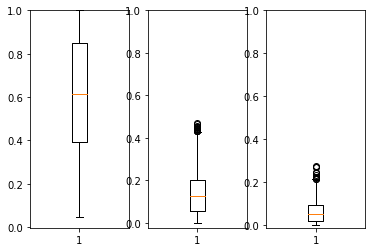

In [211]:
plt.subplot(1, 3, 1)
plt.boxplot(images_df[images_df.p1_dog == True].p1_conf)
plt.ylim(ymax=1)

plt.subplot(1, 3, 2)
plt.boxplot(images_df[images_df.p2_dog == True].p2_conf)
plt.ylim(ymax=1)

plt.subplot(1, 3, 3)
plt.boxplot(images_df[images_df.p3_dog == True].p3_conf)
plt.ylim(ymax=1)

plt.show()

The highest confindence predictions come from Prediction 1.

## Cleaning and Tidying Data
- Low quality (dirty) data has content issues. Fix 8 of these.
- Untidy (messy) data has structural issues. Fix 2 of these.

#### Remove Extra Archive Columns
Remove columns with data unnecessary for analysis.

In [212]:
archive_df.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id',
                         'source', 'retweeted_status_user_id',
                         'retweeted_status_timestamp'], inplace=True, errors='ignore')

#### Remove Extra Tweet Download Columns
Remove all columns except those needed for analysis.

In [213]:
tweets_df = tweets_df[['id_str', 'retweet_count', 'favorite_count']].set_index('id_str')

#### There Aren't Even Dogs in These (Remove Tweets without Dogs)
Some tweets had no dogs in them or they weren't specifically about the dog; remove these.

In [214]:
r_col = ['835152434251116546', '746906459439529985', '670842764863651840', '855862651834028034', '810984652412424192']
archive_df.drop(index=r_col, inplace=True, errors='ignore')

#### Remove Retweets and Tweets with No Photos
We love them all, but we want to see original tweets with photos.

In [215]:
archive_df = archive_df[archive_df.retweeted_status_id.isna() &
                        ~archive_df.expanded_urls.isna()]
len(archive_df)

2113

After removal of retweets and tweets without photos, 2114 tweets remain.

#### DoggoLingo (Tidy Structure)
Combine *doggo, floofer, pupper,* and *puppo* columns in to a single *doggolingo* variable.

In [216]:
cols = ['doggo', 'floofer', 'pupper', 'puppo']
archive_df[cols] = archive_df[cols].replace('None', '')
archive_df['doggolingo'] = archive_df[cols].apply(lambda x: ';'.join(filter(None, x)), axis=1)

archive_df.drop(cols, axis='columns', inplace=True, errors='ignore')

#### A Dog Named None (Correct Names)

For names that are 'None' or all lower case, convert them to blanks.

In [217]:
archive_df.loc[(archive_df.name=='None') |
               (archive_df.name.str.islower()), 'name'] = ''

#### They're Good Dogs (Correct Ratings)
Update ratings that were found with incorrect denominators.

In [218]:
update_ratings = pd.DataFrame([
    {'tweet_id': '835246439529840640', 'rating_numerator': 13, 'rating_denominator': 10},
    {'tweet_id': '832088576586297345', 'rating_numerator': pd.np.nan, 'rating_denominator': pd.np.nan},
    {'tweet_id': '775096608509886464', 'rating_numerator': 14, 'rating_denominator': 10},
    {'tweet_id': '740373189193256964', 'rating_numerator': 14, 'rating_denominator': 10},
    {'tweet_id': '682962037429899265', 'rating_numerator': 10, 'rating_denominator': 10},
    {'tweet_id': '682808988178739200', 'rating_numerator': pd.np.nan, 'rating_denominator': pd.np.nan},
    {'tweet_id': '666287406224695296', 'rating_numerator': 9, 'rating_denominator': 10},
    {'tweet_id': '722974582966214656', 'rating_numerator': 13, 'rating_denominator': 10},
    {'tweet_id': '716439118184652801', 'rating_numerator': 11, 'rating_denominator': 10},
    {'tweet_id': '680494726643068929', 'rating_numerator': 11.26, 'rating_denominator': 10},
    {'tweet_id': '778027034220126208', 'rating_numerator': 11.27, 'rating_denominator': 10},
    {'tweet_id': '786709082849828864', 'rating_numerator': 9.75, 'rating_denominator': 10}
]).set_index('tweet_id')

archive_df.update(update_ratings, overwrite=True)

#### Normalize Ratings
For ratings that contain multiple dogs (denominators are a multiple of 10), save a normalized numerator that is the rating out of 10.

In [219]:
archive_df['rating_numerator_normal'] = archive_df.rating_numerator / (archive_df.rating_denominator/10)

#### Award for the Most Confident Dog (Tidy Structure and Simplify Predictions)
Select the prediction that is a dog and is the most confident about dog type as the ultimate prediction.

In [220]:
# create three temporary DataFrames of info, rename columns to append all stacked
images_p1_df = images_df.reset_index()[['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog']]
images_p2_df = images_df.reset_index()[['tweet_id', 'jpg_url', 'img_num', 'p2', 'p2_conf', 'p2_dog']]
images_p3_df = images_df.reset_index()[['tweet_id', 'jpg_url', 'img_num', 'p3', 'p3_conf', 'p3_dog']]

images_p1_df.rename(columns={'p1': 'breed', 'p1_conf': 'conf', 'p1_dog': 'is_dog'}, inplace=True)
images_p2_df.rename(columns={'p2': 'breed', 'p2_conf': 'conf', 'p2_dog': 'is_dog'}, inplace=True)
images_p3_df.rename(columns={'p3': 'breed', 'p3_conf': 'conf', 'p3_dog': 'is_dog'}, inplace=True)

a = pd.DataFrame()
a = (a.append(images_p1_df)
      .append(images_p2_df)
      .append(images_p3_df)
    )

# Select only 'dog' images, then keep only the highest confidence dog image
# reset index and massage DataFrame for later use
images_df = (a[a.is_dog==True]
              .groupby(['tweet_id', 'jpg_url', 'img_num'])
              .apply(lambda x: x[x.conf==x.conf.max()])
              .drop(columns=['tweet_id', 'jpg_url', 'img_num'])
              .reset_index()
              .set_index('tweet_id')
              .drop(columns=['level_3'])
            )

#### Clean Dog Breeds
Clean the names of breeds to remove underscores and convert to title case.

In [221]:
images_df.breed = images_df.breed.str.replace('_', ' ').str.title()

#### Join Tables
Join the information from the tweet details downloaded from Twitter and image predictions to the WeRateDogs Twitter archive.

In [222]:
master_df = archive_df.join(tweets_df)
master_df = master_df.join(images_df)

## Store Twitter Archive Master
Store the final cleaned archive according to project requirements.

*Store the clean DataFrame(s) in a CSV file with the main one named twitter_archive_master.csv. If additional files exist because multiple tables are required for tidiness, name these files appropriately.*

In [223]:
master_df.to_csv('twitter_archive_master.csv')

In [224]:
master_df = pd.read_csv('twitter_archive_master.csv', parse_dates=['timestamp'])

## Visualization and Insights

#### How have ratings changed over time?

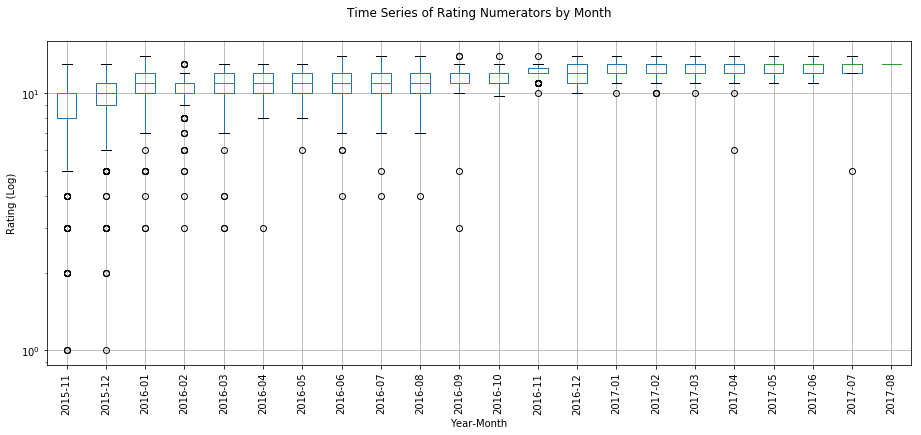

In [300]:
g = master_df[['timestamp', 'rating_numerator_normal']].set_index('timestamp')
g = g[g['rating_numerator_normal'] < 1776] # Removed Independence Day rating because of extreme outlying
g['month'] = g.index.to_period('M')

fig, ax = plt.subplots(figsize=(15,6))
g.boxplot(by='month', ax=ax, rot=90)
ax.set_yscale('log')
plt.suptitle('Time Series of Rating Numerators by Month')
plt.title('')
ax.set(xlabel='Year-Month', ylabel='Rating (Log)')
ax.plot();

In late 2015, WeRateDogs flirted with conforming to a 10-point scale. Ratings were near 10 more often than not, but ratings significantly under 10 were typically given to strange dogs (ones that have no tails and who lay eggs, such as chickens) and dogs behaving badly (such as one who was said to be driving with his eyes closed). In 2016, the median rating climbed above 10, with typically fewer than 25% of ratings lower than 10. By late 2016, ratings of 10 or lower became outliers and the median rating rose again. Ratings of 14 remain the domain of a few exceptional good boys, and any ratings higher appear to be one-offs, including:
- Snoop Dogg - 420
- a devilishly dressed doggo - 666
- a patriotic pupper on July 4 - 1776

#### Dog Names

In [235]:
# Top 10 Names
master_df.name.value_counts().nlargest(10)

Charlie    11
Lucy       11
Oliver     10
Cooper     10
Tucker      9
Penny       9
Winston     8
Lola        8
Sadie       8
Toby        7
Name: name, dtype: int64

In [234]:
# Number of Different (Unique) Names
master_df.name.nunique()

930

In [247]:
# Number of Names Used Only Once
len(master_df[['name', 'tweet_id']].groupby('name').filter(lambda x: len(x)==1))

701

In [255]:
# Tweets without Names
master_df.name.isnull().sum()

723

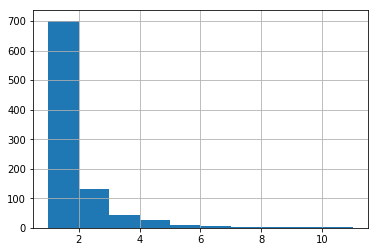

In [257]:
# Histogram of times a dog name is used
master_df.name.value_counts().hist();

Of 2.1K tweets in the analysis set, ~1.4K tweets had dog names in them. Of those, 701 had names that no other dog in the set had, and there were a total of 930 individual names. That means 219 names were used two or more times. As the histogram shows, the trend is toward unique dog names. This could change with a larger data set. The top ten dog names (and the number of times they occurred) on WeRateDogs are:

- 11: Charlie, Lucy
- 10: Oliver, Cooper
- 9: Tucker, Penny
- 8: Winston, Lola, Sadie
- 7: Toby

#### Favorite DogRates

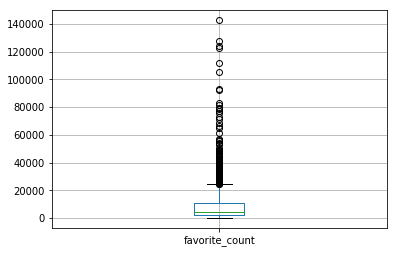

In [266]:
master_df.loc[master_df.favorite_count > 0, ['favorite_count']].boxplot();

The number of outliers for favorited count is interesting. I'll compare the outlier set to the rest of the population.

In [293]:
# Define outliers as (Q3 + 1.5 x IQR)
favorite_count_3q = master_df.favorite_count.quantile(0.75)
favorite_count_iqr = master_df.favorite_count.quantile(0.75) - master_df.favorite_count.quantile(0.25)
outlier_df = master_df.loc[master_df.favorite_count >= (favorite_count_3q+(1.5*favorite_count_iqr))]

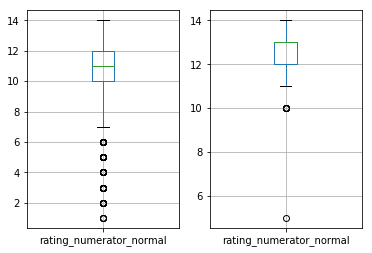

In [292]:
plt.subplot(1,2,1)
master_df.loc[master_df.rating_numerator_normal < 1776, ['rating_numerator_normal']].boxplot()
plt.subplot(1,2,2)
outlier_df[['rating_numerator_normal']].boxplot();

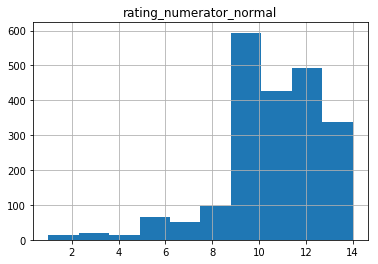

In [299]:
master_df.loc[master_df.rating_numerator_normal<1776, ['rating_numerator_normal']].hist();

The most favorited (outlier) tweets have dog ratings about 1 point higher than the median favorites of the total population. This is significant when most tweets have ratings 9-14.